<a href="https://colab.research.google.com/github/StillWork/AIDD-2208-add/blob/main/c_84_14_GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Training a Generative Adversarial Network on MNIST


- We will try to train a network to produce new images of handwritten digits.

In [1]:
!pip install --pre deepchem
import deepchem
deepchem.__version__

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 693 kB 22.3 MB/s 
     |████████████████████████████████| 29.5 MB 2.1 MB/s 


'2.6.2.dev'

In [2]:
import deepchem as dc
import tensorflow as tf
from deepchem.models.optimizers import ExponentialDecay
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Reshape
import matplotlib.pyplot as plot
import matplotlib.gridspec as gridspec
%matplotlib inline

mnist = tf.keras.datasets.mnist.load_data(path='mnist.npz')
images = mnist[0][0].reshape((-1, 28, 28, 1))/255
dataset = dc.data.NumpyDataset(images)

11490434/11490434 [==============================] - 0s 0us/step


Let's view some of the images to get an idea of what they look like.

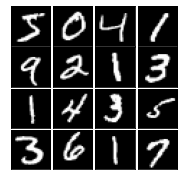

In [3]:
def plot_digits(im):
  plot.figure(figsize=(3, 3))
  grid = gridspec.GridSpec(4, 4, wspace=0.05, hspace=0.05)
  for i, g in enumerate(grid):
    ax = plot.subplot(g)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(im[i,:,:,0], cmap='gray')

plot_digits(images)

Now we can create our GAN.  which consists of two parts:

1. The generator takes random noise as its input and produces output that will hopefully resemble the training data.
2. The discriminator takes a set of samples as input (possibly training data, possibly created by the generator), and tries to determine which are which.

- We will use a different style of GAN called a Wasserstein GAN (or WGAN for short).  
 - Instead of outputting the probability of a sample being real training data, it tries to learn how to measure the distance between the training distribution and generated distribution.  
 - That measure can then be directly used as a loss function for training the generator.

- We use a very simple model.  The generator uses a dense layer to transform the input noise into a 7x7 image with eight channels.  
 - That is followed by two convolutional layers that upsample it first to 14x14, and finally to 28x28.
 
- The discriminator does roughly the same thing in reverse.  
 - Two convolutional layers downsample the image first to 14x14, then to 7x7.  
 - A final dense layer produces a single number as output.  
 - In WGAN, we instead use a softplus activation.  It produces an unbounded positive number that can be interpreted as a distance.

In [4]:
class DigitGAN(dc.models.WGAN):

  def get_noise_input_shape(self):
    return (10,)

  def get_data_input_shapes(self):
    return [(28, 28, 1)]

  def create_generator(self):
    return tf.keras.Sequential([
        Dense(7*7*8, activation=tf.nn.relu),
        Reshape((7, 7, 8)),
        Conv2DTranspose(filters=16, kernel_size=5, strides=2, activation=tf.nn.relu, padding='same'),
        Conv2DTranspose(filters=1, kernel_size=5, strides=2, activation=tf.sigmoid, padding='same')
    ])

  def create_discriminator(self):
    return tf.keras.Sequential([
        Conv2D(filters=32, kernel_size=5, strides=2, activation=tf.nn.leaky_relu, padding='same'),
        Conv2D(filters=64, kernel_size=5, strides=2, activation=tf.nn.leaky_relu, padding='same'),
        Dense(1, activation=tf.math.softplus)
    ])

gan = DigitGAN(learning_rate=ExponentialDecay(0.001, 0.9, 5000))

- As in the last tutorial, we write a generator to produce data.  This time the data is coming from a dataset, which we loop over 100 times.

- In a conventional GAN, it is important to keep the generator and discriminator in balance thoughout training.  If either one gets too far ahead, it becomes very difficult for the other one to learn.

- WGANs do not have this problem.  In fact, the better the discriminator gets, the cleaner a signal it provides and the easier it becomes for the generator to learn.  
- We therefore specify `generator_steps=0.2` so that it will only take one step of training the generator for every five steps of training the discriminator.  This tends to produce faster training and better results.

In [5]:
def iterbatches(epochs):
  for i in range(epochs):
    for batch in dataset.iterbatches(batch_size=gan.batch_size):
      yield {gan.data_inputs[0]: batch[0]}

gan.fit_gan(iterbatches(100), generator_steps=0.2, checkpoint_interval=5000)

Ending global_step 4999: generator average loss 0.384791, discriminator average loss -0.0223226
Ending global_step 9999: generator average loss 0.551351, discriminator average loss -0.00680189
Ending global_step 14999: generator average loss 0.577895, discriminator average loss -0.00769624
Ending global_step 19999: generator average loss 0.560561, discriminator average loss -0.0078209
Ending global_step 24999: generator average loss 0.5668, discriminator average loss -0.00756958
Ending global_step 29999: generator average loss 0.541152, discriminator average loss -0.00675992
Ending global_step 34999: generator average loss 0.510001, discriminator average loss -0.00527643
Ending global_step 39999: generator average loss 0.495052, discriminator average loss -0.00558866
Ending global_step 44999: generator average loss 0.461401, discriminator average loss -0.00469926
Ending global_step 49999: generator average loss 0.455452, discriminator average loss -0.00462207
Ending global_step 54999: 

Let's generate some data and see how the results look.

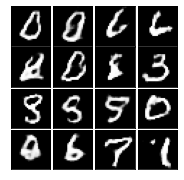

In [6]:
plot_digits(gan.predict_gan_generator(batch_size=16))

Not too bad.  Many of the generated images look plausibly like handwritten digits.  A larger model trained for a longer time can do much better, of course.

In [8]:
DigitGAN

__main__.DigitGAN